In [1]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [2]:
import rpy2
rpy2.__path__
import anndata2ri
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%reload_ext rpy2.ipython

#sc.logging.print_versions()

In [3]:
sc.settings.verbosity = 0

In [7]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('15', '10'), color_map='gist_earth')

In [ ]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',
 'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#000000'}

In [9]:
def assign_lib_from_index(adata, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in adata.obs.index.tolist()]
    adata.obs['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return adata
def assign_lib_from_index_df(df, sample_key = 'sample', csv_path = '../../../data/AGG/outs/aggr.csv'):
    aggr = pd.read_csv('../../../data/AGG/outs/aggr.csv')
    lib_idx = [int(index.split('-')[-1]) for index in df.index.tolist()]
    df['sample'] = [aggr.iloc[int(n-1)]['library_id'] for n in lib_idx]
    return df

In [10]:
adata = sc.read_10x_h5(f'../../../data/AGG/outs/filtered_feature_bc_matrix.h5')

In [11]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 115045 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [12]:
adata = assign_lib_from_index(adata)

In [13]:
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_genes(adata, min_counts=1)

In [14]:
adata.layers['counts'] = adata.X.copy()

adata.var['rb'] = adata.var_names.str.startswith(("RPS", "RPL"))

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb'], percent_top=None, log1p=False, inplace=True)

In [15]:
sample_color_dic={}
for i, j in zip(np.sort(adata.obs['sample'].unique()), sns.color_palette("tab20",len(adata.obs['sample'].unique().tolist()))):
    sample_color_dic[i]=j

In [16]:
sample_color_dic

{'lib_09': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'lib_10': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'lib_15': (1.0, 0.4980392156862745, 0.054901960784313725),
 'lib_23': (1.0, 0.7333333333333333, 0.47058823529411764),
 'lib_29': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'lib_34': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'lib_36': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'lib_38': (1.0, 0.596078431372549, 0.5882352941176471),
 'lib_51': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'lib_54': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'lib_55': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'lib_56': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'lib_57': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [17]:
df = pd.DataFrame(adata.obs['sample'].value_counts().index, index = adata.obs['sample'].value_counts().index  , columns =[ 'samples' ])
df['n_cells'] = adata.obs['sample'].value_counts().values.astype(int)

<AxesSubplot:title={'center':'Total nº of Cells'}, xlabel='samples'>

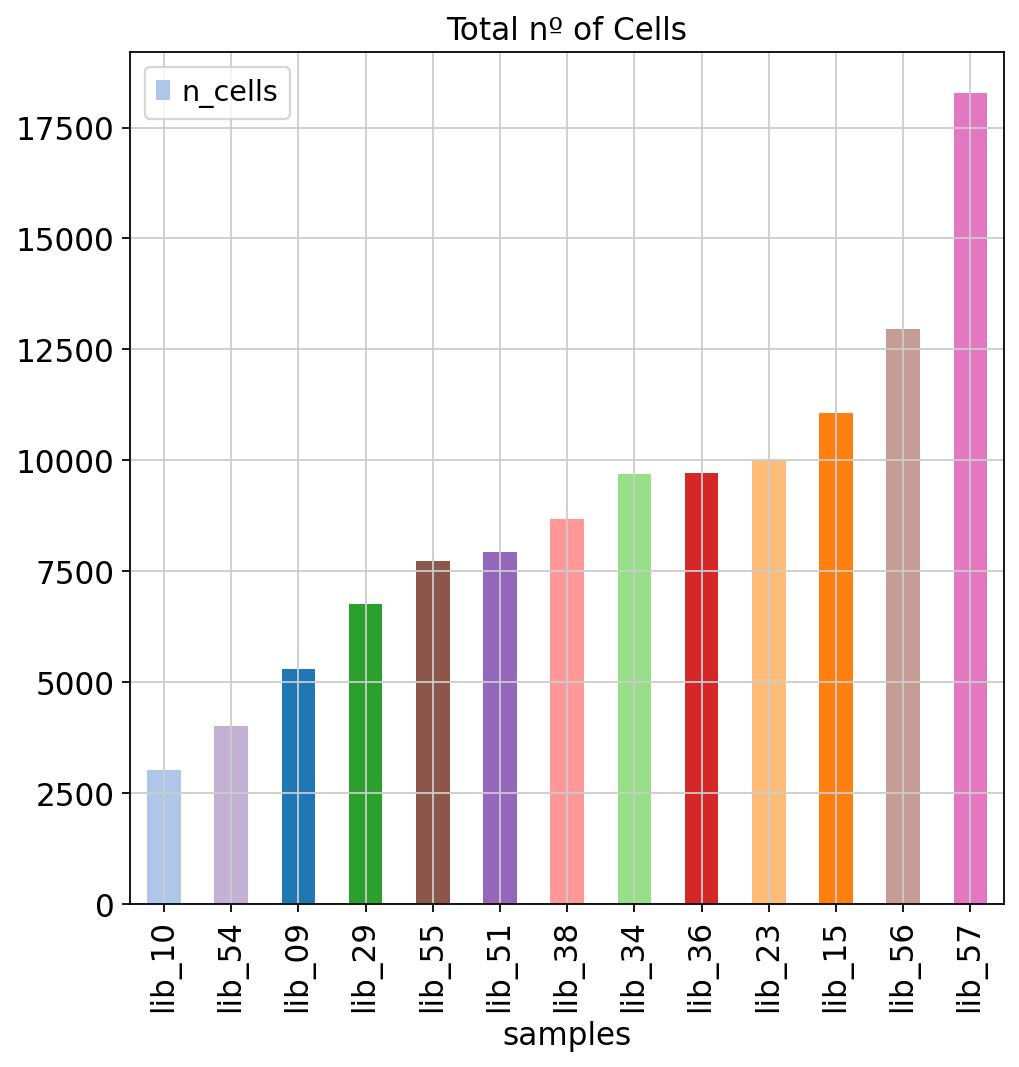

In [18]:
rcParams['figure.figsize'] = (7,7)
df.reindex(index=np.argsort(df['n_cells']).index.tolist()[::-1]).plot(kind='bar', x = 'samples', y ='n_cells', color = [sample_color_dic[i] for i in np.argsort(df['n_cells']).index.tolist()[::-1]], title = 'Total nº of Cells' )

In [19]:
adata

AnnData object with n_obs × n_vars = 115045 × 35103
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [20]:
rcParams['figure.figsize'] = (10,4)
font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 16}

plt.rc('font', **font)

In [21]:
list_val = []
list_sample = []
for i in adata.obs['sample'].unique():
    prim = adata[adata.obs['sample'].isin([i])]
    list_val.append(np.sum(prim.obs['n_genes_by_counts'])/prim.shape[0])
    list_sample.append(i)
sort_l = np.argsort(list_val)
order = [list_sample[i] for i in sort_l]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


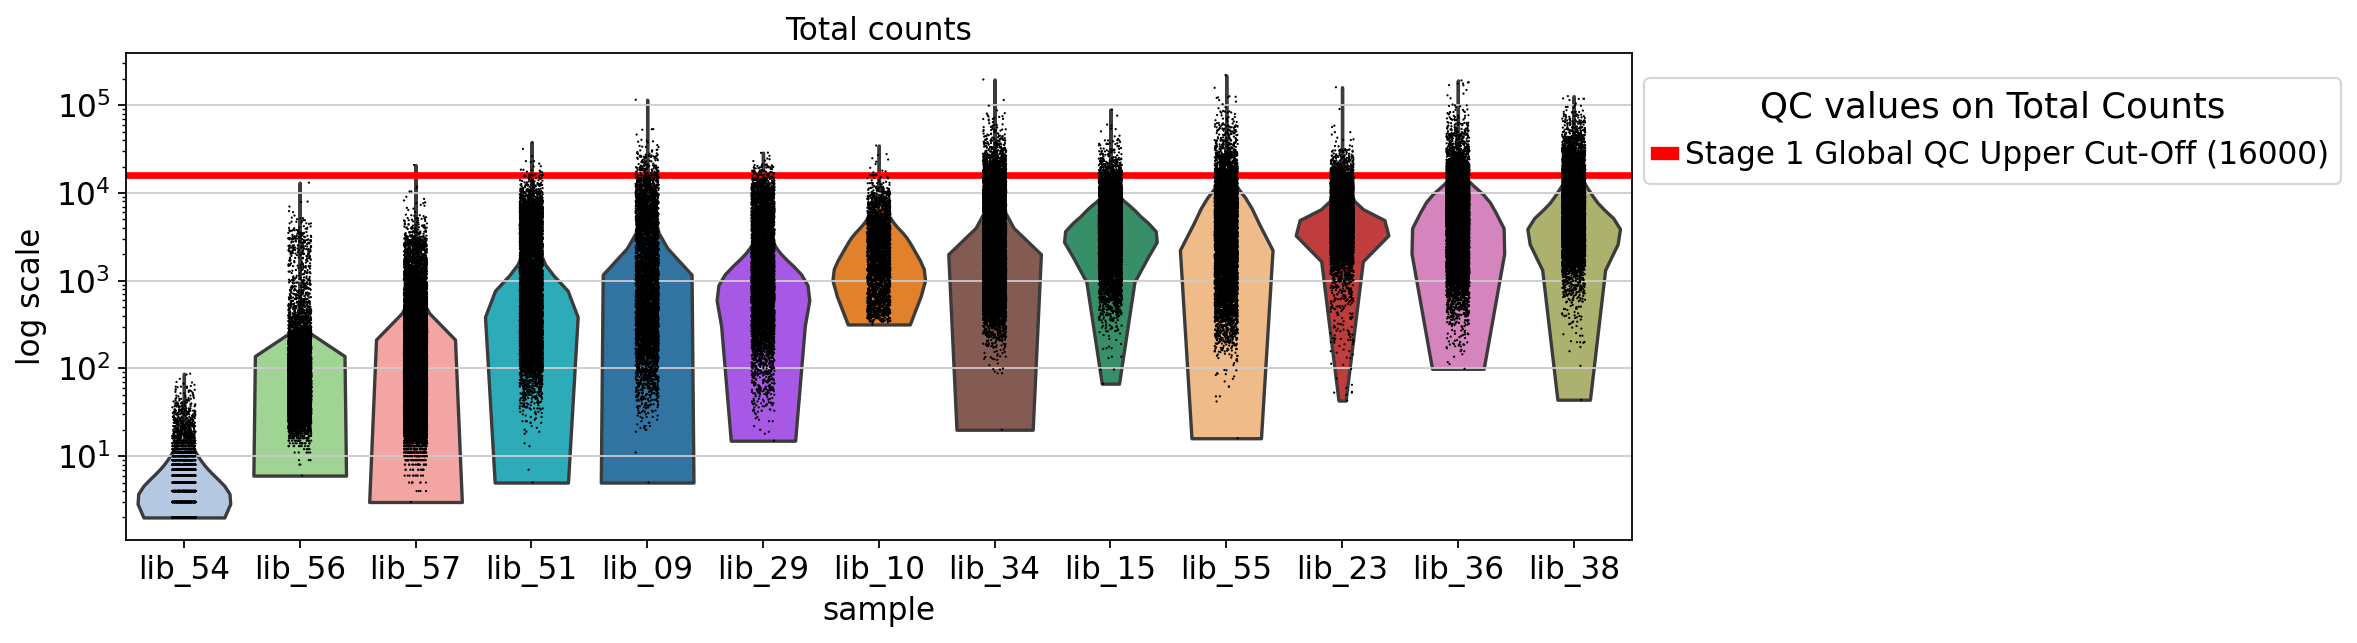

In [22]:
a = sc.pl.violin(adata, keys = ['total_counts'] ,show=False, log = True, groupby='sample',order = order)
l1 = a.axhline(16000, color='red',linewidth = 3)
a.set_title('Total counts')
a.set_ylabel('log scale')

leg = a.legend([l1],['Stage 1 Global QC Upper Cut-Off (16000)'],loc = 'lower center',fontsize = 14, title = 'QC values on Total Counts',
  fancybox=True, ncol=4,   bbox_to_anchor = (1.24, 0.7))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'figures/QC_violin_total_counts.png',  bbox_inches='tight', dpi=600)


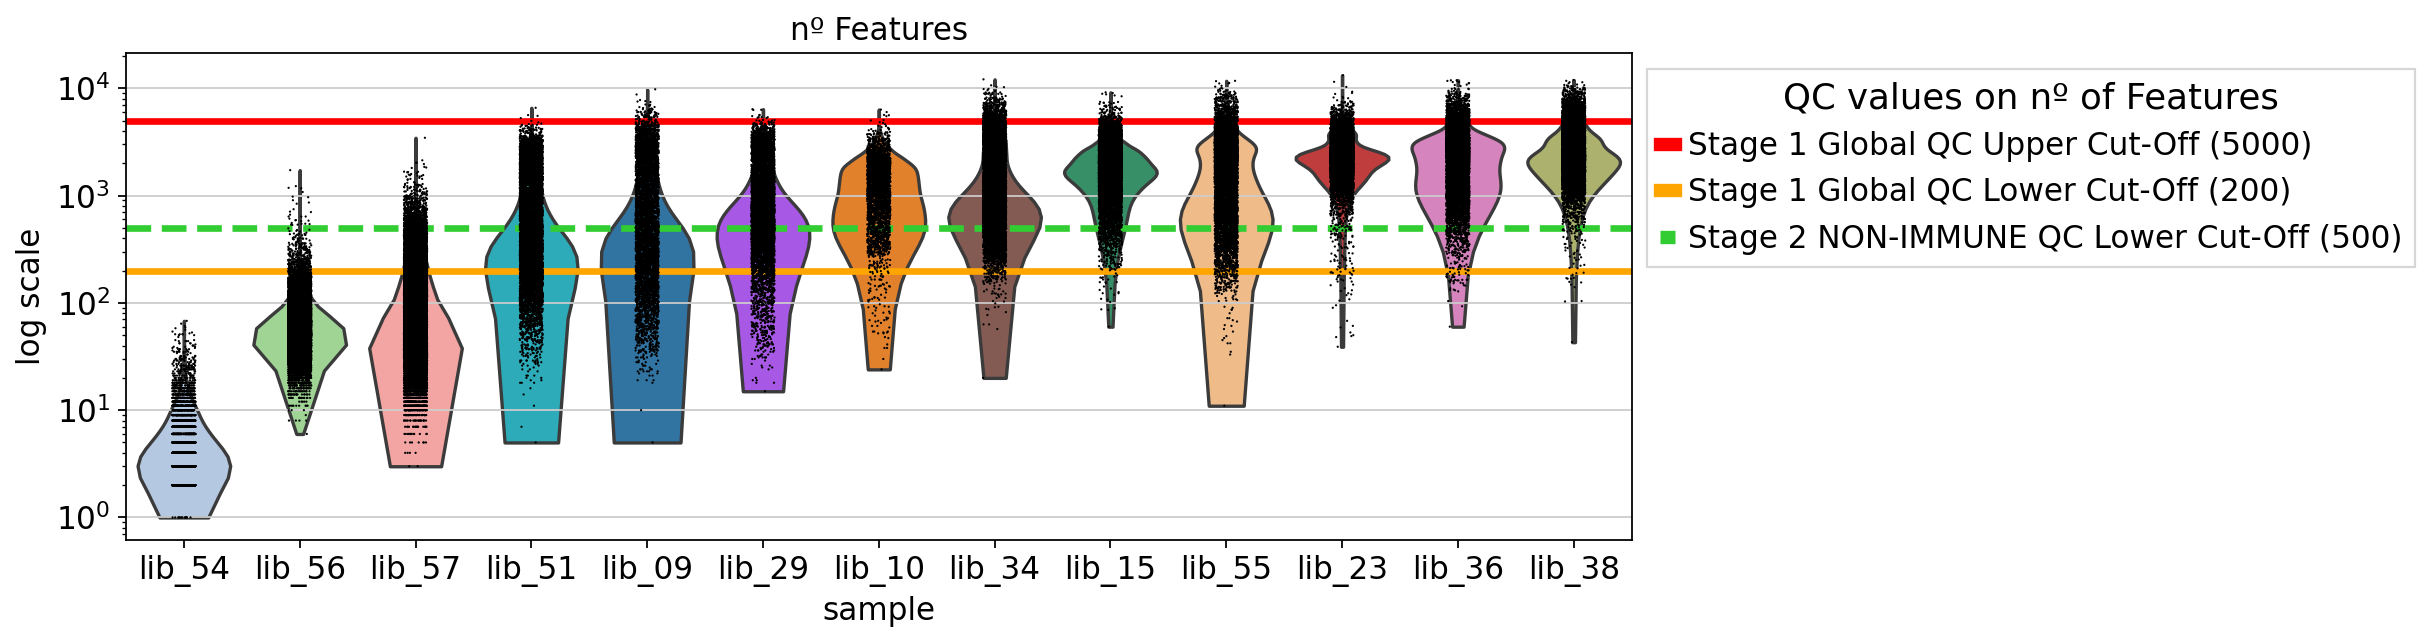

In [23]:
a = sc.pl.violin(adata, keys = ['n_genes_by_counts'] ,show=False, log = True, groupby='sample', order = order)
l1 = a.axhline(5000, color='red',linewidth = 3)
l1_5 = a.axhline(200, color='orange',linewidth = 3, )

l2 = a.axhline(500, color='limegreen', label = '2ndQC NON-IMMUNE',linewidth = 3, linestyle = '--')
a.set_title('nº Features')
a.set_ylabel('log scale')
leg = a.legend([l1,l1_5,l2],['Stage 1 Global QC Upper Cut-Off (5000)','Stage 1 Global QC Lower Cut-Off (200)','Stage 2 NON-IMMUNE QC Lower Cut-Off (500)'],fontsize = 14, title = 'QC values on nº of Features',
  fancybox=False, ncol=1,   bbox_to_anchor = (1,1))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'figures/QC_violin_n_genes_by_counts.png', bbox_inches='tight', dpi=600)


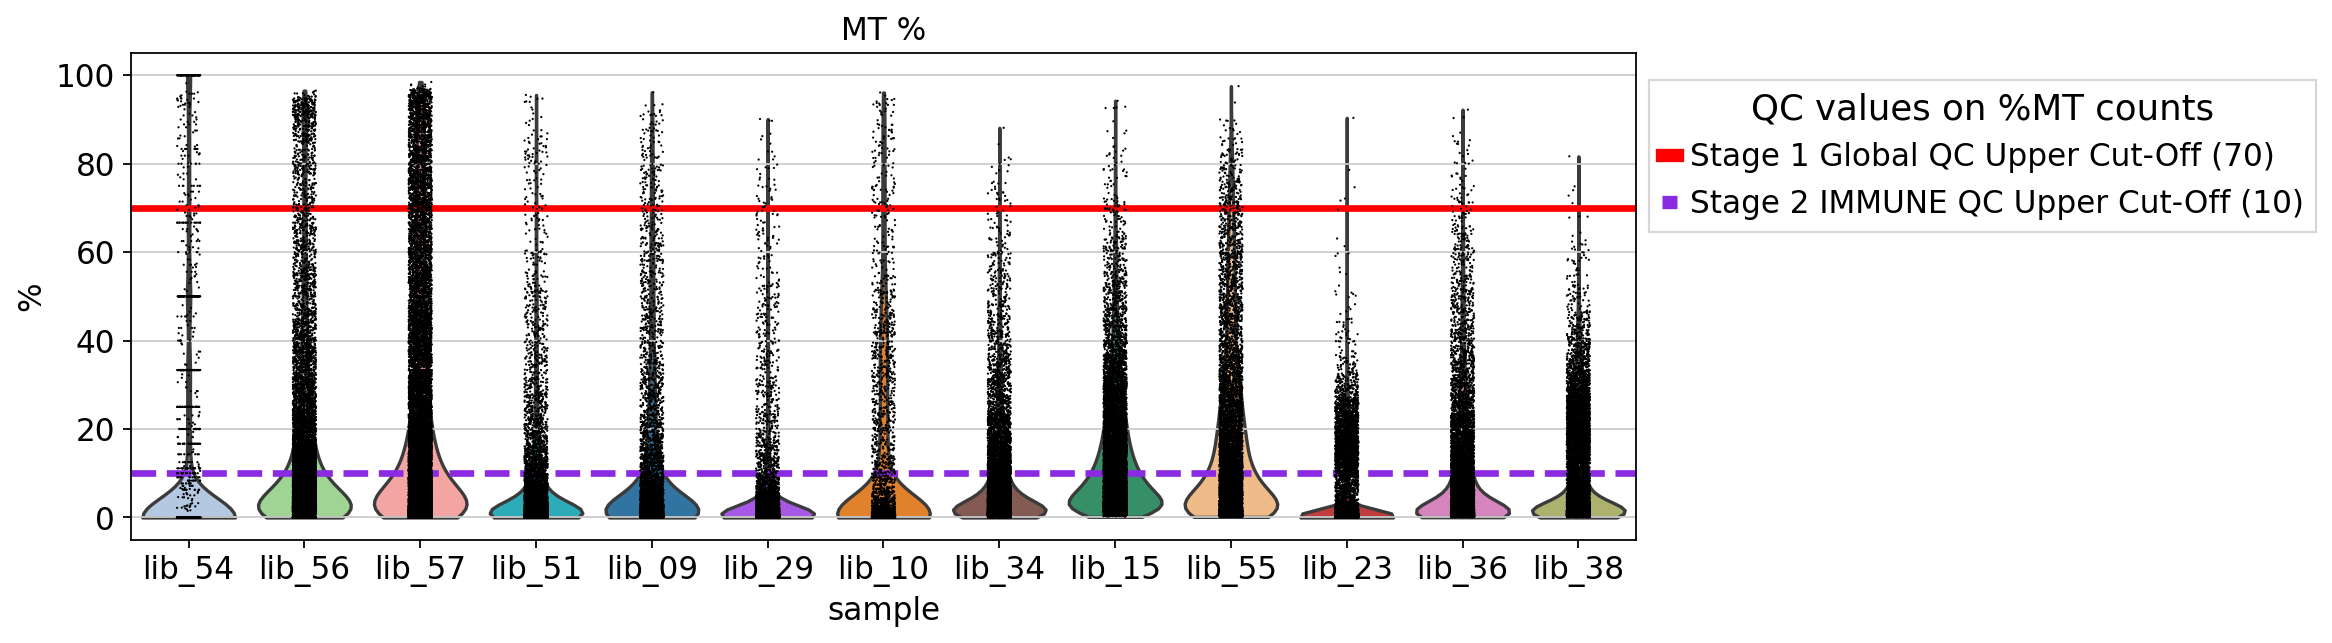

In [26]:
a = sc.pl.violin(adata, keys = ['pct_counts_mt'] ,show=False, log = False, groupby='sample', order = order)
l1 = a.axhline(70, color='red',linewidth = 3)
l1_5 = a.axhline(10, color='blueviolet',linewidth = 3, linestyle = '--')
a.set_title('MT %')
a.set_ylabel('%')

leg = a.legend([l1,l1_5],['Stage 1 Global QC Upper Cut-Off (70)','Stage 2 IMMUNE QC Upper Cut-Off (10)'],loc = 'lower center',fontsize = 14, title = 'QC values on %MT counts',
  fancybox=False, ncol=1,   bbox_to_anchor = (1.23,0.6))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'figures/QC_violins/pct_counts_mt.png', bbox_inches='tight',dpi=600)


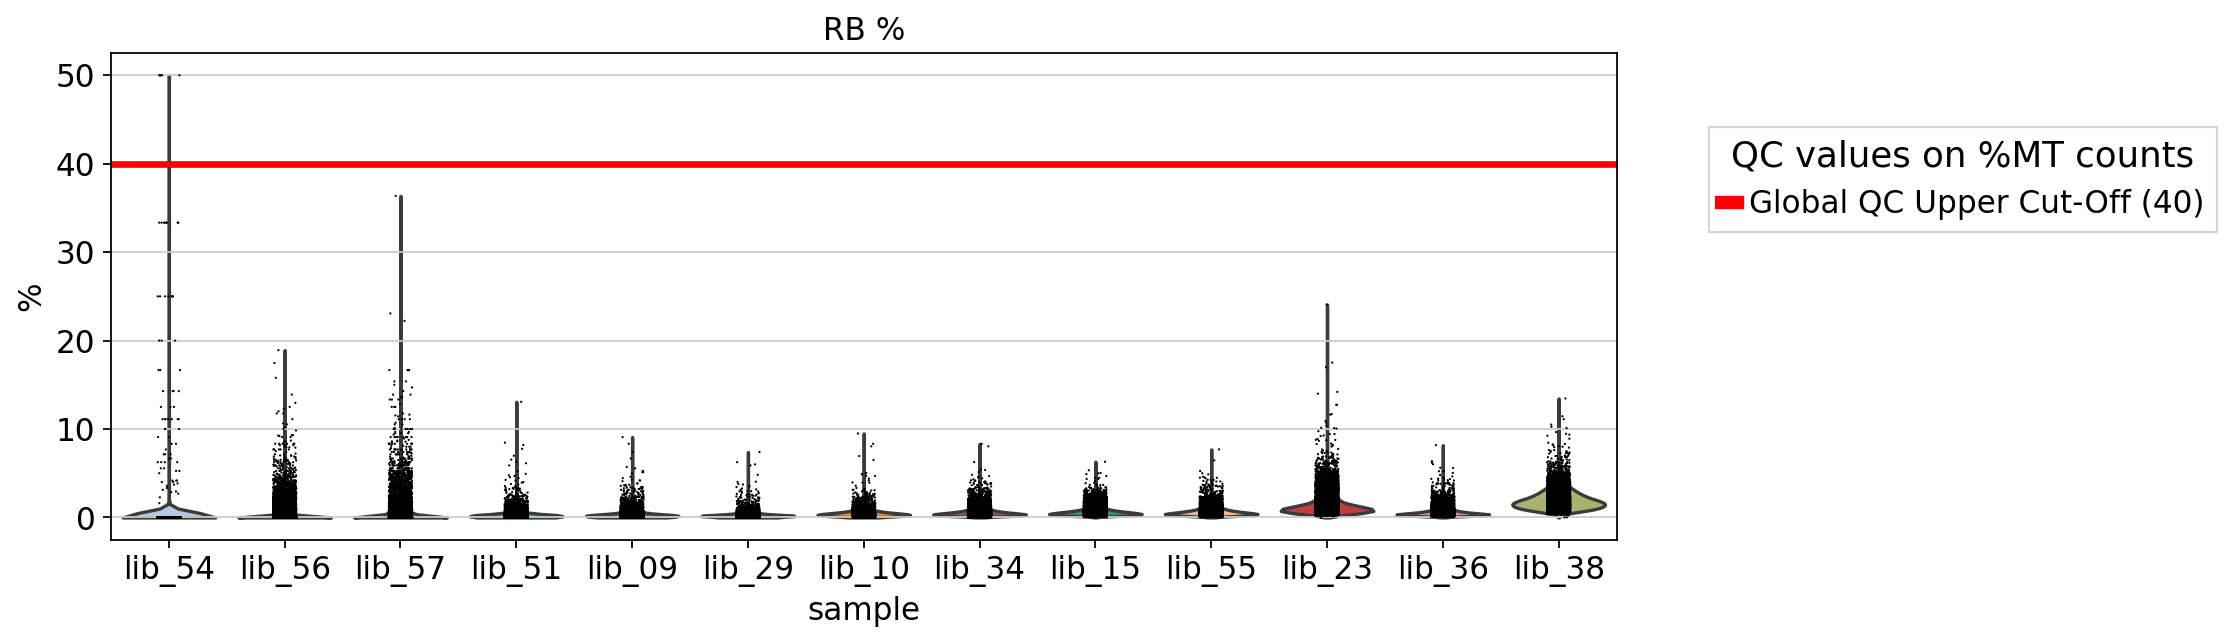

In [27]:
a = sc.pl.violin(adata, keys = ['pct_counts_rb'] ,show=False, log = False, groupby='sample', order = order)
l1 = a.axhline(40, color='red',linewidth = 3)
# l1_5 = a.axhline(10, color='blueviolet',linewidth = 3, linestyle = '--')
a.set_title('RB %')
a.set_ylabel('%')

leg = a.legend([l1],['Global QC Upper Cut-Off (40)'],loc = 'lower center',fontsize = 14, title = 'QC values on %MT counts',
  fancybox=False, ncol=1,   bbox_to_anchor = (1.23,0.6))
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.savefig(f'figures/QC_violins/pct_counts_rb.png', bbox_inches='tight',dpi=600)


In [30]:
mt_threshold = 70
rb_threshold = 40
tc_upper_threshold = 16000
nF_lower_threshold = 200
nF_upper_threshold = 5000

In [31]:
adata = adata[adata.obs['pct_counts_mt']<mt_threshold]
adata = adata[adata.obs['pct_counts_rb']<rb_threshold]
adata = adata[adata.obs['total_counts']<tc_upper_threshold]
adata = adata[adata.obs['n_genes_by_counts']>nF_lower_threshold]
adata = adata[adata.obs['n_genes_by_counts']<nF_upper_threshold]

In [32]:
adata.write('objects/merged_1stQC_.h5ad', compression = 'gzip')

In [25]:
adata = sc.read('objects/merged_1stQC.h5ad')